# Temporal Clustering

Temporal Clustering
```
# -------------------
# Prerequisites:
#    - Code in '1_get_data.R' must be run in order to download and format data
# 
# Functionality:
#
# (1) Temporal clustering using DBSCAN
#
# -------------------
```

## Module Imports

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import itertools

## 1. Data preparation

### 1.1 - Read data from file

In [2]:
# Read all data from file
data = pd.read_csv('gla_collisions_sf.csv', parse_dates=['date'])

print(data.shape, "\n")
print(data.dtypes)
data.head(2)

(67653, 44) 

X                                                       int64
Y                                                       int64
accident_index                                         object
accident_year                                           int64
accident_reference                                     object
longitude                                             float64
latitude                                              float64
police_force                                           object
accident_severity                                      object
number_of_vehicles                                      int64
number_of_casualties                                    int64
date                                           datetime64[ns]
day_of_week                                            object
time                                                   object
local_authority_district                               object
local_authority_ons_district                           o

C:\Users\Boomerang\AppData\Local\Temp\ipykernel_6488\2859428482.py:2: DtypeWarning: Columns (2,4,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('gla_collisions_sf.csv', parse_dates=['date'])


,X,Y,accident_index,accident_year,accident_reference,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,datetime,NAME,HECTARES,NONLD_AREA,POLY_ID,hour_decimal,month
0,521389,175144,2020010219808,2020,10219808,NaN,NaN,Metropolitan Police,Slight,1,...,Non-trunk,E01004576,-1,2020/02/04 09:00:00+00,London Euro Region,159469.7,2129.716,124433,9.000000,2020-02
1,529337,176237,2020010220496,2020,10220496,NaN,NaN,Metropolitan Police,Slight,1,...,Non-trunk,E01003034,-1,2020/04/27 12:55:00+00,London Euro Region,159469.7,2129.716,124433,13.916667,2020-04


In [3]:
# Rename columns to lower case x and y to avoid confusion when building models
data.rename(columns={'Y': 'y', 'X': 'x'}, inplace=True)

In [4]:
boundaries = {
    'x_max': int(data["x"].max()),
    'x_min': int(data["x"].min()),
    'y_max': int(data["y"].max()),
    'y_min': int(data["y"].min())
}
print(boundaries)

{'x_max': 561143, 'x_min': 503690, 'y_max': 200902, 'y_min': 156748}


### 1.2 - Filter rows to create 3 separate datasets for analysis; Feburary 2020, February 2021 and Feburary 2022

In [5]:
# Get data for February 2020
feb_2020 = data[data.month == '2020-01']
print(feb_2020.shape)
feb_2020.head(2)

(1947, 44)


,x,y,accident_index,accident_year,accident_reference,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,datetime,NAME,HECTARES,NONLD_AREA,POLY_ID,hour_decimal,month
2,526432,182761,2020010228005,2020,10228005,NaN,NaN,Metropolitan Police,Slight,1,...,Non-trunk,E01004726,-1,2020/01/01 01:25:00+00,London Euro Region,159469.7,2129.716,124433,1.416667,2020-01
3,538676,184371,2020010228006,2020,10228006,NaN,NaN,Metropolitan Police,Serious,1,...,Non-trunk,E01003617,-1,2020/01/01 01:50:00+00,London Euro Region,159469.7,2129.716,124433,1.833333,2020-01


In [6]:
# Get data for February 2021
feb_2021 = data[data.month == '2021-02']
print(feb_2021.shape)
feb_2021.head(2)

(1184, 44)


,x,y,accident_index,accident_year,accident_reference,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,datetime,NAME,HECTARES,NONLD_AREA,POLY_ID,hour_decimal,month
22194,541572,188756,2021010290989,2021,010290989,NaN,NaN,Metropolitan Police,Slight,2,...,Non-trunk,E01003794,-1,2021/02/01 04:00:00+00,London Euro Region,159469.7,2129.716,124433,4.000000,2021-02
22195,527646,173230,2021010290997,2021,010290997,NaN,NaN,Metropolitan Police,Slight,2,...,Non-trunk,E01004543,-1,2021/02/01 07:40:00+00,London Euro Region,159469.7,2129.716,124433,7.666667,2021-02


In [7]:
# Get data for February 2022
feb_2022 = data[data.month == '2022-02']
print(feb_2022.shape)
feb_2022.head(2)

(1664, 44)


,x,y,accident_index,accident_year,accident_reference,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,trunk_road_flag,lsoa_of_accident_location,enhanced_severity_collision,datetime,NAME,HECTARES,NONLD_AREA,POLY_ID,hour_decimal,month
45973,536032,199873,2022010357886,2022,10357886,NaN,NaN,Metropolitan Police,Slight,2,...,Non-trunk,E01001552,-1,2022/02/01 01:50:00+00,London Euro Region,159469.7,2129.716,124433,1.833333,2022-02
45976,530606,174170,2022010357890,2022,10357890,NaN,NaN,Metropolitan Police,Slight,2,...,Non-trunk,E01003171,-1,2022/02/01 05:55:00+00,London Euro Region,159469.7,2129.716,124433,5.916667,2022-02


### 1.3 - Drop columns not required; create additional columns required for analysis

In [8]:
# Feb 2020
# Drop columns not needed for the rest of the analysis. 
feb_2020 = feb_2020.loc[:, ["accident_index", "x", "y"]]
print(feb_2020.shape)
feb_2020.head(2)

(1947, 3)


,accident_index,x,y
2,2020010228005,526432,182761
3,2020010228006,538676,184371


In [9]:
# Feb 2021
# Drop columns not needed for the rest of the analysis. 
feb_2021 = feb_2021.loc[:, ["accident_index", "x", "y"]]
print(feb_2021.shape)
feb_2021.head(2)

(1184, 3)


,accident_index,x,y
22194,2021010290989,541572,188756
22195,2021010290997,527646,173230


In [10]:
# Feb 2022
# Drop columns not needed for the rest of the analysis. 
feb_2022 = feb_2022.loc[:, ["accident_index", "x", "y"]]
print(feb_2022.shape)
feb_2022.head(2)

(1664, 3)


,accident_index,x,y
45973,2022010357886,536032,199873
45976,2022010357890,530606,174170


### 1.4 - Plot data

<Axes: >

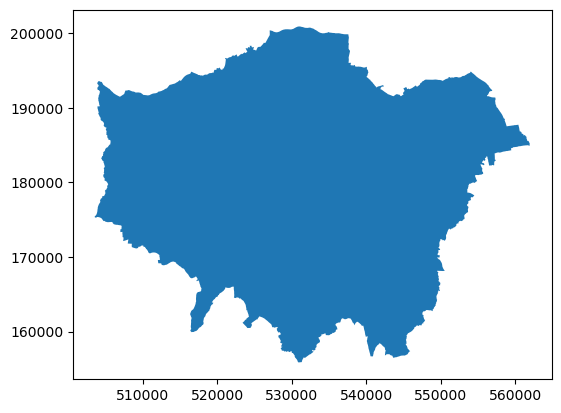

In [11]:
# Load the greater London boundary for context in visualisations
gla = gpd.read_file('./data/reference/gla_boundary/London_GLA_Boundary.shp')
gla.plot()

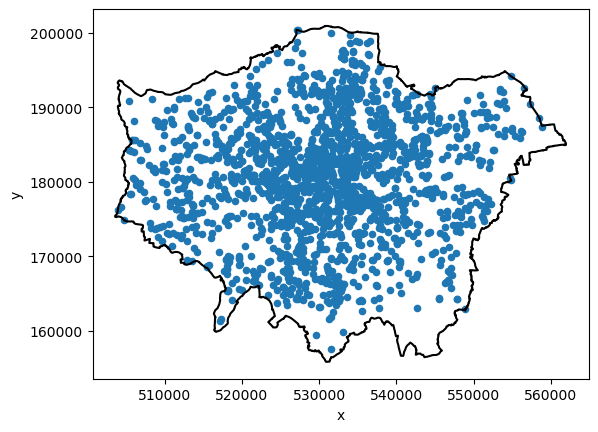

In [12]:
feb_2020.plot(kind = 'scatter', x = 'x', y = 'y')

# Add greater London border for context
gla_poly = Polygon(list(gla.get_coordinates().itertuples(index=False, name=None)))
x,y = gla_poly.exterior.xy
plt.plot(x,y,'black')


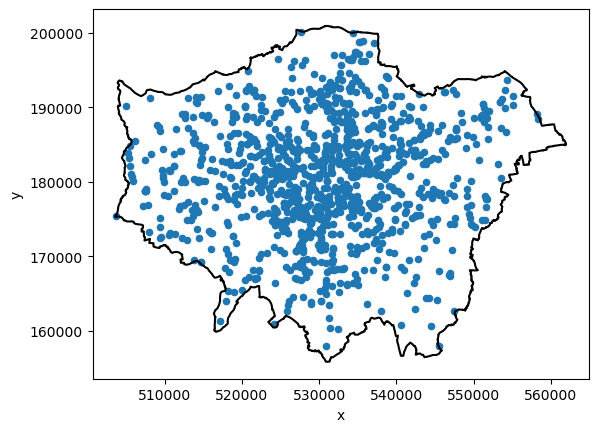

In [13]:
feb_2021.plot(kind = 'scatter', x = 'x', y = 'y')

# Add greater London border for context
gla_poly = Polygon(list(gla.get_coordinates().itertuples(index=False, name=None)))
x,y = gla_poly.exterior.xy
plt.plot(x,y,'black')


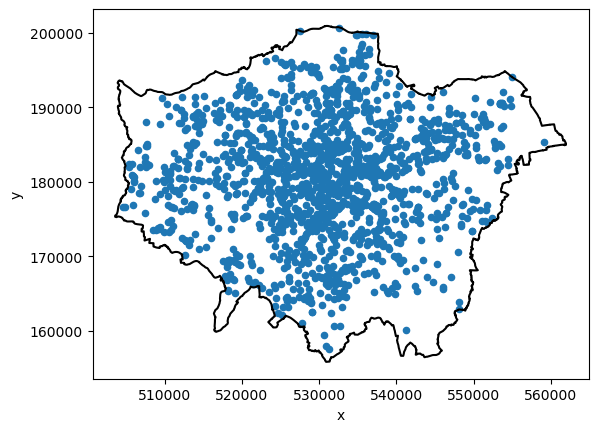

In [14]:
feb_2022.plot(kind = 'scatter', x = 'x', y = 'y')

# Add greater London border for context
gla_poly = Polygon(list(gla.get_coordinates().itertuples(index=False, name=None)))
x,y = gla_poly.exterior.xy
plt.plot(x,y,'black')


## 2. Model building and evaluation

### 2.1 Format data

In [15]:
X_2020 = feb_2020[['y','x']].to_numpy() # yx / latlon
X_2020

array([[182761, 526432],
       [184371, 538676],
       [181286, 529324],
       ...,
       [181445, 533170],
       [180959, 531837],
       [181302, 531494]])

In [16]:
X_2021 = feb_2021[['y','x']].to_numpy() # yx / latlon
X_2021

array([[188756, 541572],
       [173230, 527646],
       [186080, 546926],
       ...,
       [181631, 531556],
       [181939, 533375],
       [181179, 531619]])

In [17]:
X_2022 = feb_2022[['y','x']].to_numpy() # yx / latlon
X_2022

array([[199873, 536032],
       [174170, 530606],
       [178940, 509998],
       ...,
       [181433, 533185],
       [181443, 533192],
       [181447, 531593]])

### 2.2 Sample clustering with manual set of hyperparameters


In [18]:
dbscan_model = DBSCAN(eps=500, min_samples=5).fit(X_2020)
dbscan_model

DBSCAN(eps=500)

In [19]:
feb_2020['score'] = dbscan_model.labels_
print(feb_2020['score'].value_counts())
print(f"Total clusters: {len(feb_2020['score'].value_counts())}")

score
-1     1272
 1       54
 11      38
 7       27
 2       26
       ... 
 54       5
 71       5
 59       5
 67       4
 48       4
Name: count, Length: 73, dtype: int64
Total clusters: 73


<Axes: xlabel='x', ylabel='y'>

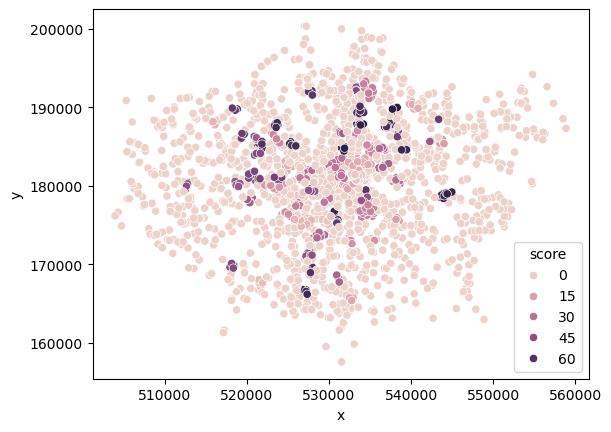

In [20]:
# With noise
sns.scatterplot(x="x", y="y", data=feb_2020, hue="score")

<Axes: xlabel='x', ylabel='y'>

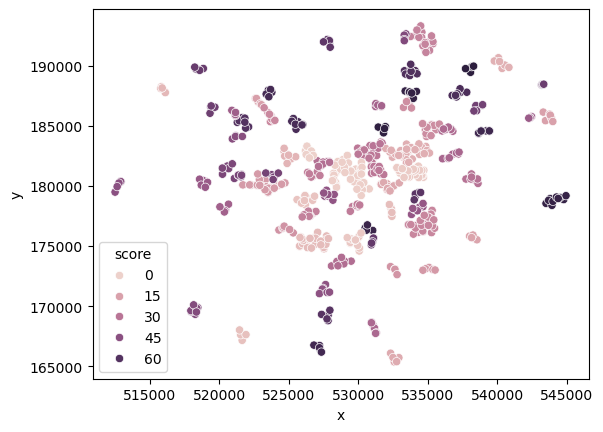

In [21]:
# Without noise
sns.scatterplot(x="x", y="y", data=feb_2020[feb_2020.score >= 0], hue="score")

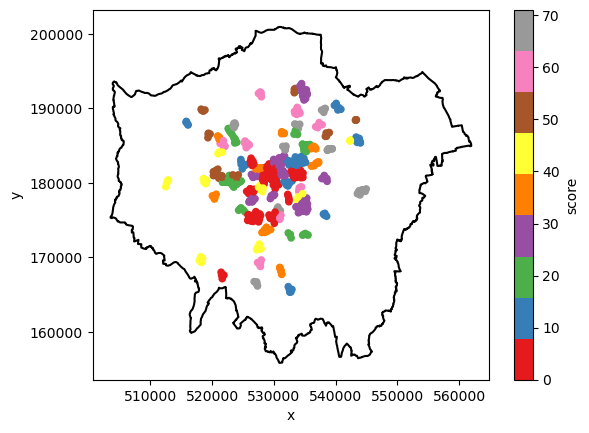

In [22]:
# Alternate plot in Matplotlib
feb_2020[feb_2020.score >= 0].plot(kind = 'scatter', x = 'x', y = 'y', c="score", cmap="Set1")

# Add greater London border for context
gla_poly = Polygon(list(gla.get_coordinates().itertuples(index=False, name=None)))
x,y = gla_poly.exterior.xy
plt.plot(x,y,'black')


In [23]:
# Get score for the sample (manual run) of DBSCAN)
silhouette_score(X_2020,feb_2020['score'])

np.float64(-0.361644531288105)

### 2.2 Custom built GridDBSCAN class and hyperparameter grid search
Custom grid search class that implements the scikitlearn DBSCAN class

In [24]:
# Grid for gridsearch

# epsilon1 - The spatial density threshold (maximum spatial distance) between two points to be considered related.
epsilon1 = [e1 for e1 in range(100, 1100, 100)]

# min_samples - The number of samples required for a core point.
min_samples = [s for s in range(3, 11, 1)]

param_grid_min_2 = {
    'eps': epsilon1,
    'min_samples':min_samples
}
print(len(param_grid_min_2['eps']), len(param_grid_min_2['min_samples']))
print("Total combinations = ", len(param_grid_min_2['eps']) *  len(param_grid_min_2['min_samples']))

param_grid_min_2

10 8
Total combinations =  80


{'eps': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'min_samples': [3, 4, 5, 6, 7, 8, 9, 10]}

In [25]:
# Class that contains the functionality for running a grid search using the Scikit-learn DBSCAN Python library. 

class GridDBSCAN():
    def __init__(self, p_grid, boundaries):
        self.eps = p_grid['eps']
        self.min_samples = p_grid['min_samples']
        self.scores = {}
        self.X = None
        self.labels = None
        self.boundaries = boundaries

    def run_grid_search(self, X):
        self.X = X
        iterables = [self.eps, self.min_samples]
        x = 0

        for t in itertools.product(*iterables):
            silhouette_avg = 0

            dbscan1 = DBSCAN(eps = t[0], min_samples = t[1]) 
            dbscan1.fit(X[['y','x']]) 

            labels = dbscan1.labels_

            if len(set(labels)) > 1:
                silhouette_avg = silhouette_score(X[['y', 'x']], labels)
            else:
                silhouette_avg = -1
                
            print(f"{t} - Silhouette Score: {silhouette_avg}")

            self.scores[t] = silhouette_avg

            x += 1
        
        print("Total completed: ", x)
        self.best_params = max(self.scores, key=self.scores.get)

        print(f"Best parameters: {self.best_params} with a score of {self.scores[self.best_params]}")
    
    def run_best_params(self):
        print(f"Running DBSCAN for 'best' parameters: {self.best_params}")

        dbscan1 = DBSCAN(eps = self.best_params[0], min_samples = self.best_params[1]) 
        dbscan1.fit(self.X[['y','x']])

        self.bp_labels = dbscan1.labels_ # best parameter labels

        self.get_cluster_count()

    def get_cluster_count(self):
        vc_df = pd.DataFrame({'cluster': self.bp_labels})
        print(vc_df.value_counts())

    def plot_results(self, hide_noise=False, title='ST-DBSCAN Clustering'):
        print(f"Results for DBSCAN for parameters: {self.best_params}")
        x_tmp = self.X
        x_tmp["cluster"] = self.bp_labels
        
        if hide_noise:
            x_tmp = x_tmp[(x_tmp.cluster != -1)]
        
        # Plot results
        fig, ax = plt.subplots()
        ax = sns.scatterplot(x="x", y="y", data=x_tmp, hue="cluster", palette="tab10")
        ax.get_legend().remove()
        ax.set_xlim([self.boundaries['x_min'], self.boundaries['x_max']])
        ax.set_ylim([self.boundaries['y_min'], self.boundaries['y_max']])


        # Add greater London border for context
        gla_poly = Polygon(list(gla.get_coordinates().itertuples(index=False, name=None)))
        x,y = gla_poly.exterior.xy
        plt.plot(x,y,'black')
        plt.show()


        # Interpretation
        n_clusters = len(set(self.bp_labels)) - (1 if -1 in self.bp_labels else 0)
        n_noise = list(self.bp_labels).count(-1)
        print(f'Estimated number of clusters: {n_clusters}')
        print(f'Estimated number of noise points: {n_noise}')

        if hide_noise:
            print("\nData:")
            print(x_tmp[["x","y","cluster"]])

    


#### February 2020

(100, 3) - Silhouette Score: -0.6926626892547193
(100, 4) - Silhouette Score: -0.3966760300495606
(100, 5) - Silhouette Score: -1
(100, 6) - Silhouette Score: -1
(100, 7) - Silhouette Score: -1
(100, 8) - Silhouette Score: -1
(100, 9) - Silhouette Score: -1
(100, 10) - Silhouette Score: -1
(200, 3) - Silhouette Score: -0.5857141432308741
(200, 4) - Silhouette Score: -0.6719906454961588
(200, 5) - Silhouette Score: -0.555375822982586
(200, 6) - Silhouette Score: -0.09210455660023341
(200, 7) - Silhouette Score: -1
(200, 8) - Silhouette Score: -1
(200, 9) - Silhouette Score: -1
(200, 10) - Silhouette Score: -1
(300, 3) - Silhouette Score: -0.36041571368327124
(300, 4) - Silhouette Score: -0.5604171399282791
(300, 5) - Silhouette Score: -0.6274714064580658
(300, 6) - Silhouette Score: -0.48287763289745683
(300, 7) - Silhouette Score: -0.2953072950817513
(300, 8) - Silhouette Score: -0.31490600924833484
(300, 9) - Silhouette Score: -1
(300, 10) - Silhouette Score: -1
(400, 3) - Silhouette 

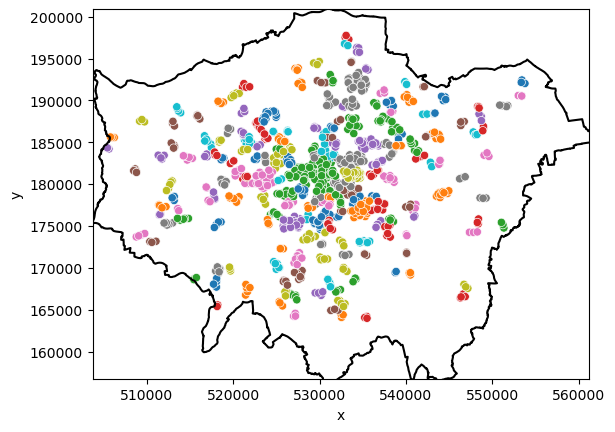

Estimated number of clusters: 199
Estimated number of noise points: 713

Data:
            x       y  cluster
2      526432  182761        0
3      538676  184371        1
4      529324  181286        2
5      537193  177105        3
7      536115  182297        4
...       ...     ...      ...
20921  531509  181630        2
20922  532784  181533        8
20926  533170  181445        8
20940  531837  180959        2
20941  531494  181302        2

[1234 rows x 3 columns]


In [26]:
dbscan_feb_2020 = GridDBSCAN(param_grid_min_2, boundaries)
dbscan_feb_2020.run_grid_search(feb_2020)
dbscan_feb_2020.run_best_params()
dbscan_feb_2020.plot_results(hide_noise=True)

In [27]:
dbscan_feb_2020.X["cluster"].value_counts()

cluster
-1      713
 2      103
 7       38
 46      36
 24      28
       ... 
 177      3
 182      3
 185      3
 189      3
 193      3
Name: count, Length: 200, dtype: int64

In [28]:
# Clusters (excluding noise)
clust_2020 = len(dbscan_feb_2020.X["cluster"].value_counts()) - 1
clust_2020

199

In [29]:
# Best parameters
print(f"Feb 2020 best parameters: {dbscan_feb_2020.best_params}, with a silhouette score of {dbscan_feb_2020.scores[dbscan_feb_2020.best_params]} and {clust_2020} clusters")


Feb 2020 best parameters: (500, 3), with a silhouette score of -0.027141324598084708 and 199 clusters


#### February 2021

(100, 3) - Silhouette Score: -0.6603430054161602
(100, 4) - Silhouette Score: -0.36687786183438353
(100, 5) - Silhouette Score: -1
(100, 6) - Silhouette Score: -1
(100, 7) - Silhouette Score: -1
(100, 8) - Silhouette Score: -1
(100, 9) - Silhouette Score: -1
(100, 10) - Silhouette Score: -1
(200, 3) - Silhouette Score: -0.5884306267926853
(200, 4) - Silhouette Score: -0.5597694234308659
(200, 5) - Silhouette Score: -0.31765251885811857
(200, 6) - Silhouette Score: -0.188578701402155
(200, 7) - Silhouette Score: -1
(200, 8) - Silhouette Score: -1
(200, 9) - Silhouette Score: -1
(200, 10) - Silhouette Score: -1
(300, 3) - Silhouette Score: -0.4580208710023707
(300, 4) - Silhouette Score: -0.5702353565056275
(300, 5) - Silhouette Score: -0.5347819337886179
(300, 6) - Silhouette Score: -0.37177871065149604
(300, 7) - Silhouette Score: -0.3619774298464125
(300, 8) - Silhouette Score: -1
(300, 9) - Silhouette Score: -1
(300, 10) - Silhouette Score: -1
(400, 3) - Silhouette Score: -0.32247505

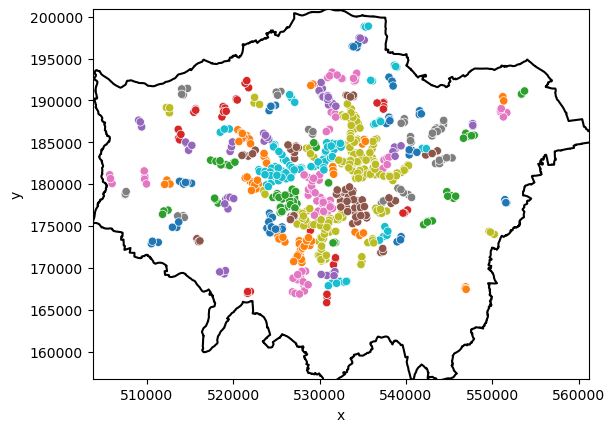

Estimated number of clusters: 112
Estimated number of noise points: 363

Data:
            x       y  cluster
22194  541572  188756        0
22195  527646  173230        1
22200  546926  186080        2
22202  537306  189236        3
22203  523515  186065        4
...       ...     ...      ...
43960  530845  174842       28
43968  532030  193023       96
44005  531556  181631      111
44015  533375  181939        8
44017  531619  181179      111

[821 rows x 3 columns]


In [30]:
dbscan_feb_2021 = GridDBSCAN(param_grid_min_2, boundaries)
dbscan_feb_2021.run_grid_search(feb_2021)
dbscan_feb_2021.run_best_params()
dbscan_feb_2021.plot_results(hide_noise=True)

In [31]:
dbscan_feb_2021.X["cluster"].value_counts()

cluster
-1      363
 8      114
 28      50
 29      46
 22      32
       ... 
 89       3
 92       3
 99       3
 111      3
 103      3
Name: count, Length: 113, dtype: int64

In [32]:
# Clusters (excluding noise)
clust_2021 = len(dbscan_feb_2021.X["cluster"].value_counts()) - 1
clust_2021

112

In [33]:
# Best parameters
print(f"Feb 2021 best parameters: {dbscan_feb_2021.best_params}, with a silhouette score of {dbscan_feb_2021.scores[dbscan_feb_2020.best_params]} and {clust_2021} clusters") 


Feb 2021 best parameters: (700, 3), with a silhouette score of -0.1779081174175093 and 112 clusters


#### February 2022

(100, 3) - Silhouette Score: -0.698940134919212
(100, 4) - Silhouette Score: -0.4301621661709066
(100, 5) - Silhouette Score: 0.3381688370169319
(100, 6) - Silhouette Score: -1
(100, 7) - Silhouette Score: -1
(100, 8) - Silhouette Score: -1
(100, 9) - Silhouette Score: -1
(100, 10) - Silhouette Score: -1
(200, 3) - Silhouette Score: -0.5959756733575938
(200, 4) - Silhouette Score: -0.623957729705656
(200, 5) - Silhouette Score: -0.5359858903598185
(200, 6) - Silhouette Score: -0.4448733268181759
(200, 7) - Silhouette Score: -1
(200, 8) - Silhouette Score: -1
(200, 9) - Silhouette Score: -1
(200, 10) - Silhouette Score: -1
(300, 3) - Silhouette Score: -0.4183842637732638
(300, 4) - Silhouette Score: -0.5721333389503674
(300, 5) - Silhouette Score: -0.5798748177562879
(300, 6) - Silhouette Score: -0.5587232273851704
(300, 7) - Silhouette Score: -0.46002274657581144
(300, 8) - Silhouette Score: -0.388221419925095
(300, 9) - Silhouette Score: -1
(300, 10) - Silhouette Score: -1
(400, 3) - 

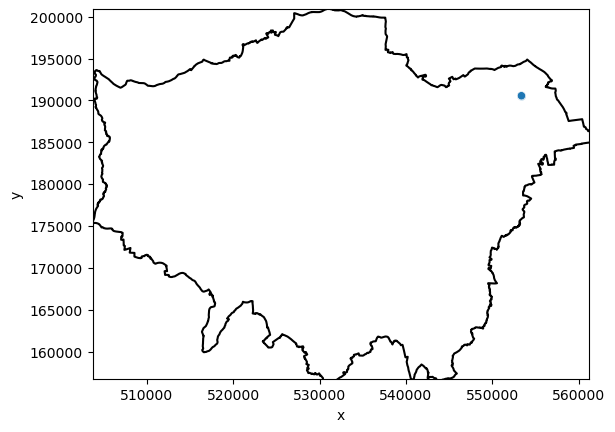

Estimated number of clusters: 1
Estimated number of noise points: 1659

Data:
            x       y  cluster
46633  553354  190541        0
46710  553351  190499        0
47445  553372  190498        0
47601  553420  190472        0
49968  553371  190554        0


In [34]:
dbscan_feb_2022 = GridDBSCAN(param_grid_min_2, boundaries)
dbscan_feb_2022.run_grid_search(feb_2022)
dbscan_feb_2022.run_best_params()
dbscan_feb_2022.plot_results(hide_noise=True)

In [35]:
dbscan_feb_2022.X["cluster"].value_counts()

cluster
-1    1659
 0       5
Name: count, dtype: int64

In [36]:
# Clusters (excluding noise)
clust_2022 = len(dbscan_feb_2022.X["cluster"].value_counts()) - 1
clust_2022

1

In [37]:
# Best parameters
print(f"Feb 2022 best parameters: {dbscan_feb_2022.best_params}, with a silhouette score of {dbscan_feb_2022.scores[dbscan_feb_2020.best_params]} and {clust_2022} clusters")


Feb 2022 best parameters: (100, 5), with a silhouette score of -0.08346048522706416 and 1 clusters


## Trying to work out the difference in 2022 clusters

In [38]:
# How many total collisions?
print(f"Collisions in Feb 2020: {len(feb_2020)}")
print(f"Collisions in Feb 2021: {len(feb_2021)}")
print(f"Collisions in Feb 2022: {len(feb_2022)}")

Collisions in Feb 2020: 1947
Collisions in Feb 2021: 1184
Collisions in Feb 2022: 1664


Feb 2020 best parameters: (500, 3), with a silhouette score of -0.027141324598084708 and 199 clusters

Feb 2021 best parameters: (700, 3), with a silhouette score of -0.1779081174175093 and 112 clusters

Feb 2022 best parameters: (100, 5), with a silhouette score of -0.08346048522706416 and 1 clusters

*Try same hyperparameters for all clusters*

(700, 3) - Silhouette Score: -0.08228422071568225
Total completed:  1
Best parameters: (700, 3) with a score of -0.08228422071568225
Running DBSCAN for 'best' parameters: (700, 3)
cluster
 0         574
-1         373
 1          42
 33         39
 7          36
          ... 
 140         3
 142         3
 144         3
 145         3
 146         3
Name: count, Length: 148, dtype: int64
Results for DBSCAN for parameters: (700, 3)


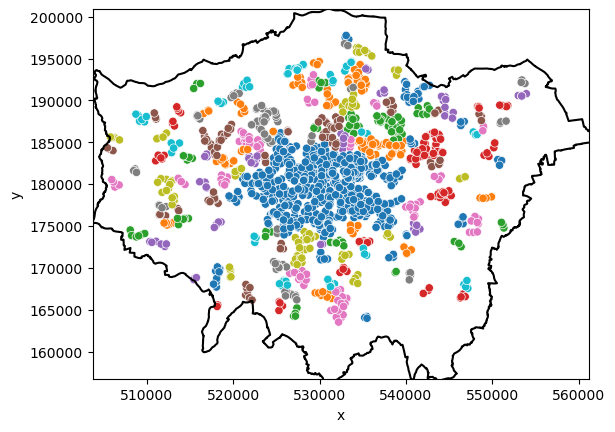

Estimated number of clusters: 147
Estimated number of noise points: 373

Data:
            x       y  cluster
2      526432  182761        0
3      538676  184371        1
4      529324  181286        0
5      537193  177105        0
7      536115  182297        0
...       ...     ...      ...
20921  531509  181630        0
20922  532784  181533        0
20926  533170  181445        0
20940  531837  180959        0
20941  531494  181302        0

[1574 rows x 3 columns]


In [39]:
# 2020
comp_feb_2020 = GridDBSCAN({'eps': [700], 'min_samples': [3]}, boundaries)
comp_feb_2020.run_grid_search(feb_2020)
comp_feb_2020.run_best_params()
comp_feb_2020.plot_results(hide_noise=True)

In [40]:
cl_comp_feb_2020 = len(comp_feb_2020.X["cluster"].value_counts()) - 1

# Best parameters
print(f"Feb 2020 best parameters: {comp_feb_2020.best_params}, with a silhouette score of {comp_feb_2020.scores[comp_feb_2020.best_params]} and {cl_comp_feb_2020} clusters") 

Feb 2020 best parameters: (700, 3), with a silhouette score of -0.08228422071568225 and 147 clusters


(700, 3) - Silhouette Score: -0.06858453994052688
Total completed:  1
Best parameters: (700, 3) with a score of -0.06858453994052688
Running DBSCAN for 'best' parameters: (700, 3)
cluster
-1         363
 8         114
 28         50
 29         46
 22         32
          ... 
 107         3
 108         3
 109         3
 110         3
 111         3
Name: count, Length: 113, dtype: int64
Results for DBSCAN for parameters: (700, 3)


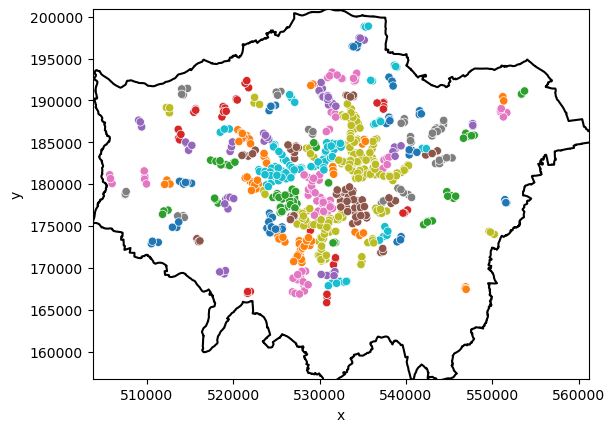

Estimated number of clusters: 112
Estimated number of noise points: 363

Data:
            x       y  cluster
22194  541572  188756        0
22195  527646  173230        1
22200  546926  186080        2
22202  537306  189236        3
22203  523515  186065        4
...       ...     ...      ...
43960  530845  174842       28
43968  532030  193023       96
44005  531556  181631      111
44015  533375  181939        8
44017  531619  181179      111

[821 rows x 3 columns]


In [41]:
# 2021
comp_feb_2021 = GridDBSCAN({'eps': [700], 'min_samples': [3]}, boundaries)
comp_feb_2021.run_grid_search(feb_2021)
comp_feb_2021.run_best_params()
comp_feb_2021.plot_results(hide_noise=True)

In [42]:
cl_comp_feb_2021 = len(comp_feb_2021.X["cluster"].value_counts()) - 1

# Best parameters
print(f"Feb 2021 best parameters: {comp_feb_2021.best_params}, with a silhouette score of {comp_feb_2021.scores[comp_feb_2021.best_params]} and {cl_comp_feb_2021} clusters") 

Feb 2021 best parameters: (700, 3), with a silhouette score of -0.06858453994052688 and 112 clusters


(700, 3) - Silhouette Score: -0.038912710747116656
Total completed:  1
Best parameters: (700, 3) with a score of -0.038912710747116656
Running DBSCAN for 'best' parameters: (700, 3)
cluster
 1         394
-1         381
 36         52
 15         35
 26         31
          ... 
 119         3
 120         3
 121         3
 122         3
 123         3
Name: count, Length: 125, dtype: int64
Results for DBSCAN for parameters: (700, 3)


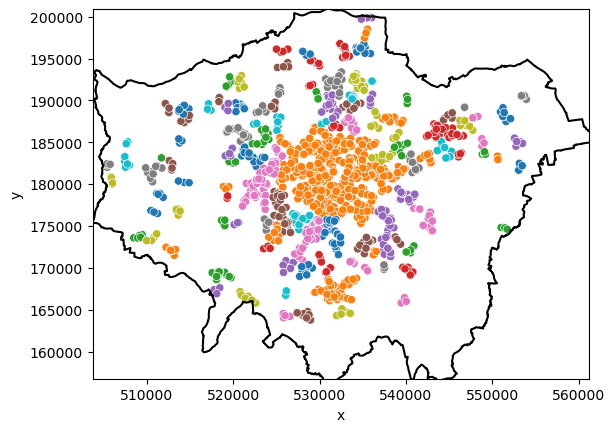

Estimated number of clusters: 124
Estimated number of noise points: 381

Data:
            x       y  cluster
45973  536032  199873       54
45976  530606  174170        0
45980  521511  180089       36
45983  536876  181677        1
45984  511676  183126        2
...       ...     ...      ...
67503  532921  180831        1
67504  533394  181993        1
67505  533185  181433        1
67506  533192  181443        1
67509  531593  181447        1

[1283 rows x 3 columns]


In [43]:
# 2022
comp_feb_2022 = GridDBSCAN({'eps': [700], 'min_samples': [3]}, boundaries)
comp_feb_2022.run_grid_search(feb_2022)
comp_feb_2022.run_best_params()
comp_feb_2022.plot_results(hide_noise=True)

In [44]:
cl_comp_feb_2022 = len(comp_feb_2022.X["cluster"].value_counts()) - 1

# Best parameters
print(f"Feb 2022 best parameters: {comp_feb_2022.best_params}, with a silhouette score of {comp_feb_2022.scores[comp_feb_2022.best_params]} and {cl_comp_feb_2022} clusters") 

Feb 2022 best parameters: (700, 3), with a silhouette score of -0.038912710747116656 and 124 clusters


In [45]:
db = DBSCAN(eps=700, min_samples=3).fit(feb_2022)
labels = db.labels_

In [46]:
df = pd.DataFrame({'labels':labels})
df['labels'].value_counts()

labels
-1     1314
 39      18
 38      13
 49       9
 41       9
       ... 
 72       3
 77       3
 74       3
 76       3
 78       3
Name: count, Length: 81, dtype: int64

<Axes: xlabel='x', ylabel='y'>

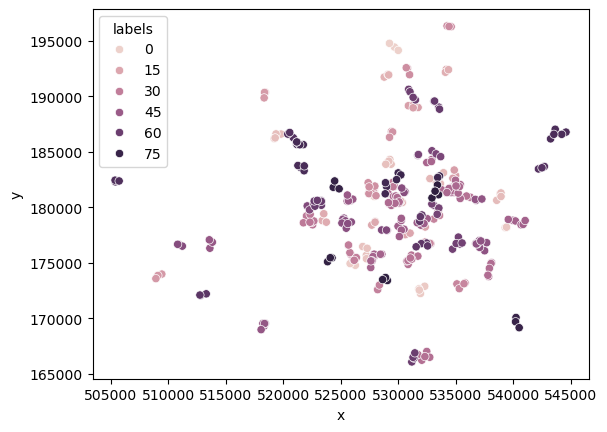

In [47]:
x_temp = feb_2022
x_temp['labels'] = labels
sns.scatterplot(x="x", y="y", data=x_temp[x_temp.labels != -1], hue="labels")